<a href="https://colab.research.google.com/github/KhoaLearn/Vinamilk-Joint-Stock-company-Investigating-Value-at-Risk-with-Historical-method-and-AR-1--Garch-1-1/blob/main/Mini_project_FRM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 4.2 MB/s 
     |████████████████████████████████| 9.8 MB 46.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
pip install arch

     |████████████████████████████████| 902 kB 4.2 MB/s 


In [3]:
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t, chi2, f
import statsmodels.api as sm
import statsmodels
import statistics
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
import requests
from bs4 import BeautifulSoup
from datetime import datetime
# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning libraries
from statsmodels.tsa.stattools import adfuller
from scipy.stats.stats import jarque_bera

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


In [4]:
def smape(y_true,y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Take data

In [5]:
VNM = pd.read_csv('https://raw.githubusercontent.com/KhoaLearn/Vinamilk-Joint-Stock-company-Investigating-Value-at-Risk-with-Historical-method-and-AR-1--Garch-1-1/main/miniproject_data.csv', index_col = 0)
VNM.index = pd.to_datetime(VNM.index)
VNM.head()

,Open,High,Low,Close,Volume,Log return %
2022-01-17,84.7,85.0,83.9,84.1,931900.0,-0.710903
2022-01-14,83.1,85.1,82.7,84.7,2516600.0,1.907090
2022-01-13,83.1,83.7,82.9,83.1,1711600.0,0.000000
2022-01-12,83.7,83.8,82.7,83.1,2183600.0,-0.719428
2022-01-11,83.7,84.0,83.5,83.7,1829000.0,0.000000


# Statistical analysis

1. Mean, standard deviation, skewness, kurtosis, median, max, min, percentile.

In [6]:
def describe_data(data):
  des_table = pd.DataFrame(data.describe())
  des_table.at['Skewness',:] = stats.skew(data)
  des_table.at['Kurtosis',:] = stats.kurtosis(data)
  return(des_table)

In [7]:
describe_data(VNM['Log return %'])

,Log return %
count,3004.000000
mean,0.075522
std,1.503720
min,-7.261435
25%,-0.711639
50%,0.000000
75%,0.766421
max,6.756791
Skewness,0.153643
Kurtosis,3.160037


2. Normal - Jarque bera test, Stationary test - adfuller, autocorrelation - box test.


In [8]:
def test_data(data):
  #null hypothesis: non stationary
  p1 = adfuller(data, autolag = 'AIC')[1] 
  print(f'p-value for stationary: {p1}')
  if p1 < 0.05:
    print('The data is stationary')
  else:
    print('The data is non-stationary')

  auto = sm.stats.acorr_ljungbox(data, lags = [40])
  p2 = auto.at[40, 'lb_pvalue']
  print(f'p-value for auto-correlation: {p2}')
  if p2 < 0.05:
    print('Auto-correlation exists')
  else:
    print('Auto-correlation does not exist')

  jb = stats.jarque_bera(data)[1]
  print(f'p-value for normal: {jb}')
  if jb < 0.05:
    print('The data is not normally distributed')
  else:
    print('The data is normally distributed')

In [9]:
test_data(VNM['Log return %'])

p-value for stationary: 0.0
The data is stationary
p-value for auto-correlation: 0.46486481623905557
Auto-correlation does not exist
p-value for normal: 0.0
The data is not normally distributed


3. Plot histogram, daily return, acf, pacf.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


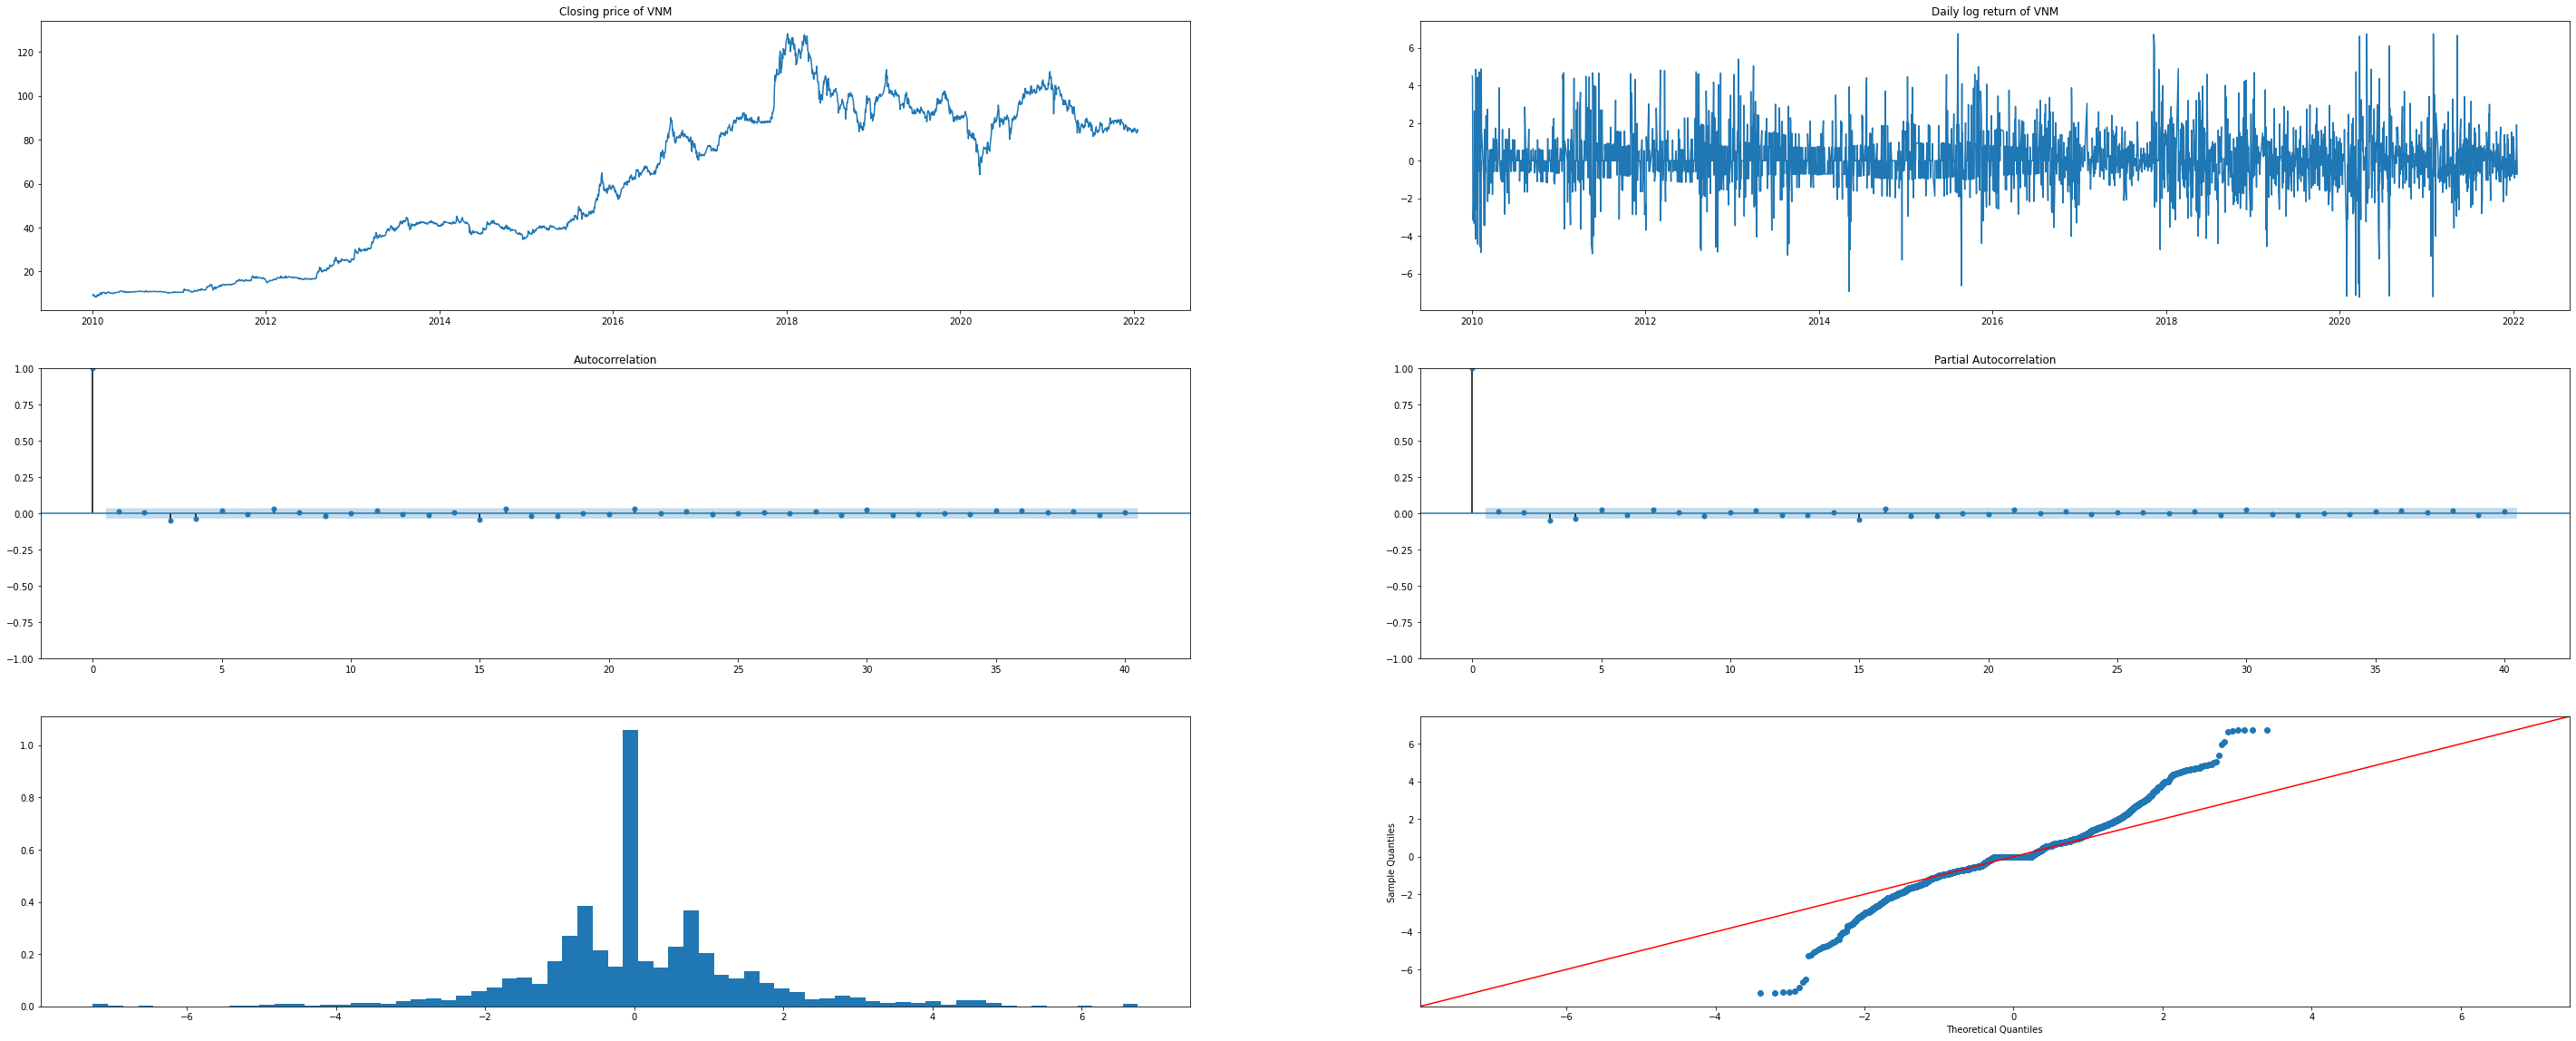

In [10]:
fig, ax = plt.subplots(3, 2, figsize = (50,20))

ax[0,0].plot(VNM['Close'])
ax[0,0].set_title('Closing price of VNM')

ax[0,1].plot(VNM['Log return %'])
ax[0,1].set_title('Daily log return of VNM')

sm.graphics.tsa.plot_acf(VNM['Log return %'], lags=40, ax = ax[1,0])

sm.graphics.tsa.plot_pacf(VNM['Log return %'], lags=40, ax = ax[1,1])

ax[2,0].hist(VNM['Log return %'], bins = 'auto', density = True)

sm.qqplot(VNM['Log return %'], line = '45', ax = ax[2,1])

plt.show()

# Historical simulation to estimate VaR

Window size 500

In [11]:
His_VaR95_500 = []
His_VaR99_500 = []

for i in range(len(VNM) - 500):
  temp = VNM[0+i:500+i].copy()
  temp = temp.sort_values(by = 'Log return %', ascending = False)
  His_VaR95_500.append(temp.iloc[int(0.95*len(temp))]['Log return %'])
  His_VaR99_500.append(temp.iloc[int(0.99*len(temp))]['Log return %'])

Window size 1000

In [12]:
His_VaR95_1000 = []
His_VaR99_1000 = []

for i in range(len(VNM) - 1000):
  temp = VNM[0+i:1000+i].copy()
  temp = temp.sort_values(by = 'Log return %', ascending = False)
  His_VaR95_1000.append(temp.iloc[int(0.95*len(temp))]['Log return %'])
  His_VaR99_1000.append(temp.iloc[int(0.99*len(temp))]['Log return %'])

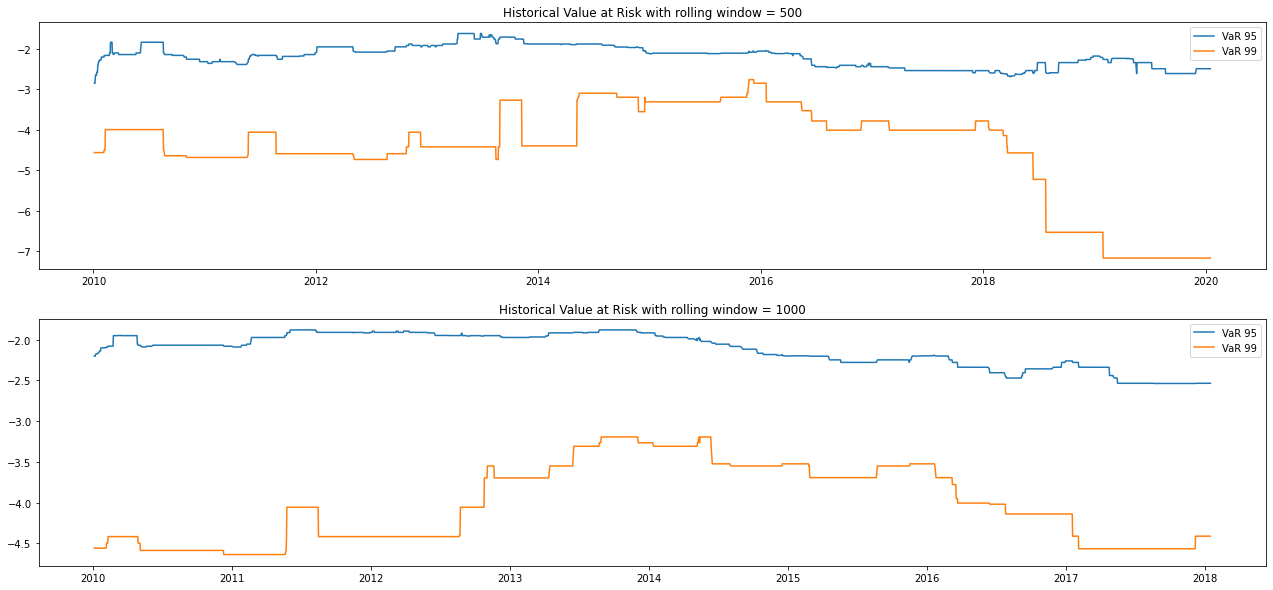

In [13]:
fig, ax = plt.subplots(2, figsize = (22,10))

ax[0].plot(VNM.index[500:len(VNM)], His_VaR95_500, label = 'VaR 95')
ax[0].plot(VNM.index[500:len(VNM)], His_VaR99_500, label = 'VaR 99')

ax[0].set_title('Historical Value at Risk with rolling window = 500')
ax[0].legend()

ax[1].plot(VNM.index[1000:len(VNM)], His_VaR95_1000, label = 'VaR 95')
ax[1].plot(VNM.index[1000:len(VNM)], His_VaR99_1000, label = 'VaR 99')

ax[1].set_title('Historical Value at Risk with rolling window = 1000')
ax[1].legend()

plt.show()

# AR-GARCH(1,1) to estimate VaR

In [14]:
VNM = VNM.sort_index(ascending = True)

In [15]:
in_sample = VNM[0:len(VNM) - 10].copy()
out_of_sample = VNM[len(VNM) - 10: len(VNM)].copy()

# In-sample predicting

In [16]:
train_len = 0.7
train = in_sample[0:int(train_len*len(in_sample))].copy()
test = in_sample[int(train_len*len(in_sample)):len(in_sample)].copy()

In [17]:
#fit model
arma = sm.tsa.ARIMA(in_sample['Log return %'], order = (1,0,0))
arma_results = arma.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [18]:
print(arma_results.summary())

                               SARIMAX Results                                
Dep. Variable:           Log return %   No. Observations:                 2994
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -5472.572
Date:                Fri, 20 May 2022   AIC                          10951.145
Time:                        02:24:45   BIC                          10969.158
Sample:                             0   HQIC                         10957.625
                               - 2994                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0761      0.028      2.725      0.006       0.021       0.131
ar.L1          0.0121      0.012      1.034      0.301      -0.011       0.035
sigma2         2.2655      0.037     61.590      0.0

In [19]:
#predict
arma_predictions = pd.DataFrame()
arma_predictions["Mean predictions"] = arma_results.predict(start = test.index[0], end = test.index[-1])

In [20]:
### GARCH
resid_df = in_sample.copy()
resid_df["resid"] = resid_df["Log return %"].shift(1).loc[resid_df.index]
resid_df["resid"] = arma_results.resid

resid_model = arch_model(resid_df["resid"][1:], p = 1, q = 1, vol = "GARCH", mean = 'Zero')
resid_model_results = resid_model.fit(last_obs = test.index[0], update_freq = 5)

Iteration:      5,   Func. Count:     36,   Neg. LLF: 3580.698990499034
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3580.6588248069534
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9


In [21]:
print(resid_model_results.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  resid   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3580.66
Distribution:                  Normal   AIC:                           7167.32
Method:            Maximum Likelihood   BIC:                           7184.26
                                        No. Observations:                 2094
Date:                Fri, May 20 2022   Df Residuals:                     2094
Time:                        02:24:46   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1044  3.387e-02      3.082  2.059e-03 [3.800e-0

In [22]:
resid_forecasts = resid_model_results.forecast(reindex = False).residual_variance.loc[test.index].values

results_in_sample = arma_predictions.copy()
results_in_sample['Standard deviation'] = np.sqrt(resid_forecasts.reshape(-1,))
results_in_sample['Predicted upper returns'] = results_in_sample['Mean predictions'] + results_in_sample['Standard deviation']**2
results_in_sample['Predicted lower returns'] = results_in_sample['Mean predictions'] - results_in_sample['Standard deviation']**2
results_in_sample['Estimated VaR 95'] = results_in_sample['Mean predictions'] - results_in_sample['Standard deviation']*norm.ppf(0.95)
results_in_sample['Estimated VaR 99'] = results_in_sample['Mean predictions'] - results_in_sample['Standard deviation']*norm.ppf(0.99)

results_in_sample  

,Mean predictions,Standard deviation,Predicted upper returns,Predicted lower returns,Estimated VaR 95,Estimated VaR 99
2018-06-06,0.099404,2.053842,4.317670,-4.118862,-3.278865,-4.678547
2018-06-07,0.061400,1.942424,3.834413,-3.711613,-3.133604,-4.457355
2018-06-08,0.091068,1.790324,3.296329,-3.114194,-2.853754,-4.073850
2018-06-11,0.073172,1.763008,3.181368,-3.035024,-2.826718,-4.028197
2018-06-12,0.096256,1.634962,2.769358,-2.576847,-2.593018,-3.707236
...,...,...,...,...,...,...
2021-12-27,0.093677,1.018230,1.130470,-0.943116,-1.581163,-2.275081
2021-12-28,0.076501,1.017794,1.112405,-0.959403,-1.597621,-2.291241
2021-12-29,0.066747,0.988116,1.043121,-0.909627,-1.558560,-2.231956
2021-12-30,0.071030,0.951194,0.975800,-0.833740,-1.493545,-2.141778


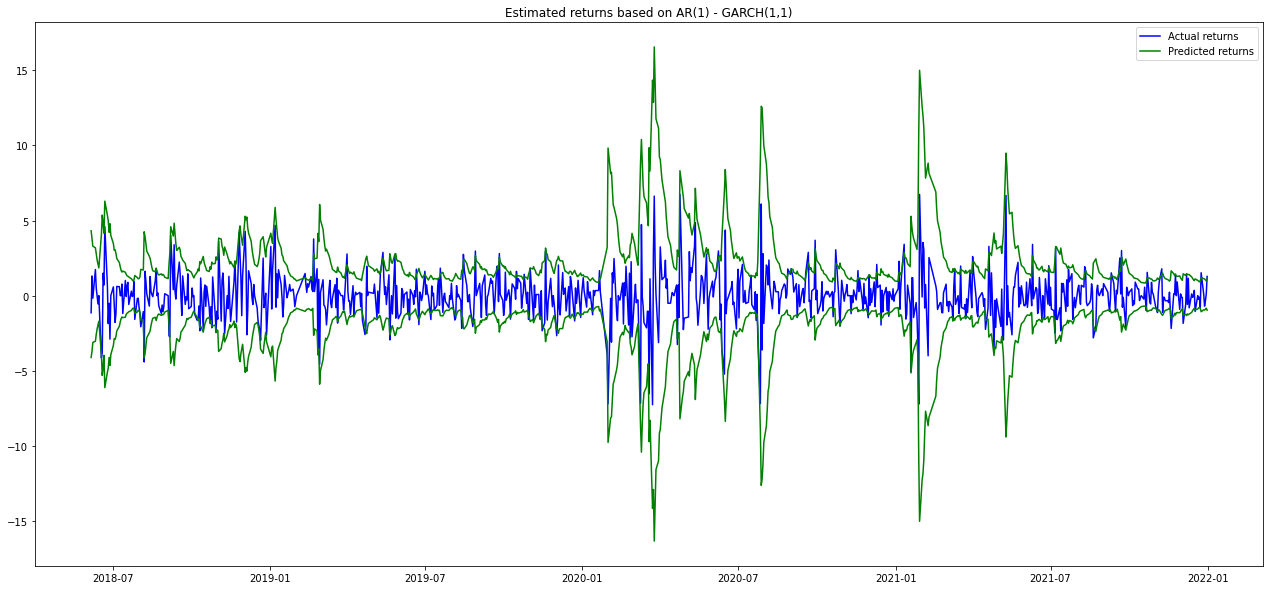

In [23]:
plt.figure(figsize = (22,10))
plt.plot(test.index, test['Log return %'], color = 'blue', label = 'Actual returns')
plt.plot(results_in_sample['Predicted upper returns'], color = 'green', label = 'Predicted returns')
plt.plot(results_in_sample['Predicted lower returns'], color = 'green')
plt.legend()
plt.title(f'Estimated returns based on AR(1) - GARCH(1,1)')
plt.show()

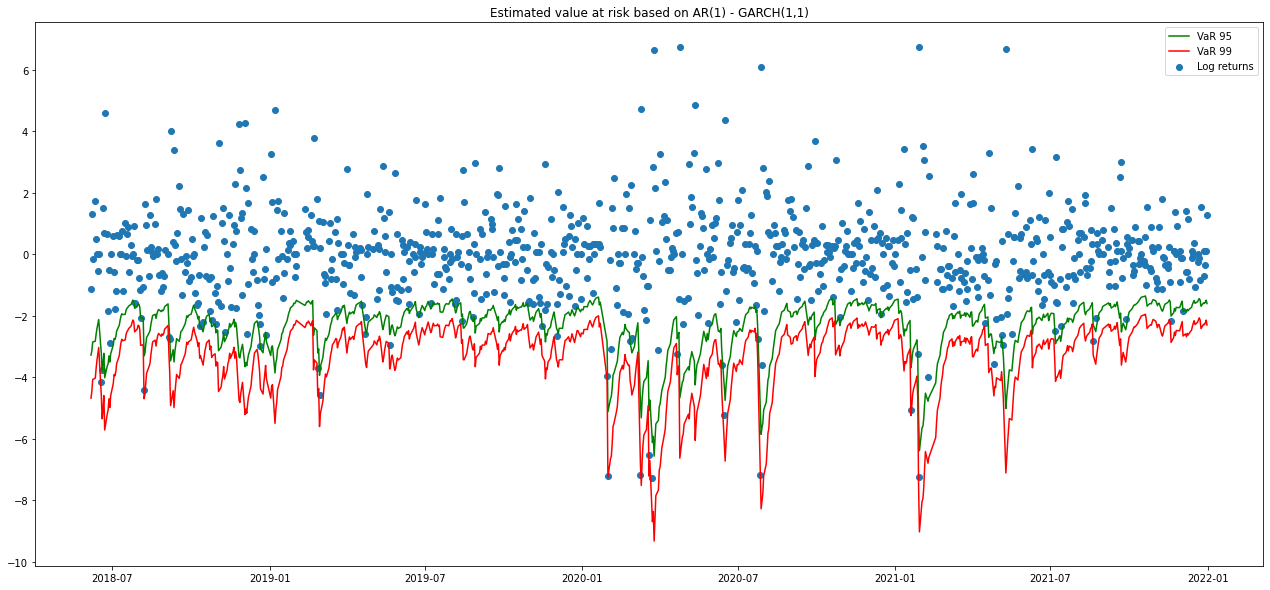

In [24]:
plt.figure(figsize = (22,10))
plt.scatter(test.index, test['Log return %'], label = 'Log returns')
plt.plot(results_in_sample['Estimated VaR 95'], color = 'green', label = 'VaR 95')
plt.plot(results_in_sample['Estimated VaR 99'], color = 'red', label = 'VaR 99')
plt.legend()
plt.title(f'Estimated value at risk based on AR(1) - GARCH(1,1)')
plt.show()

In [25]:
excess_VaR95 = 0
excess_VaR99 = 0

for i in test.index:
  if results_in_sample.at[i, 'Estimated VaR 95'] > test.at[i, 'Log return %']:
    excess_VaR95 += 1
  
  if results_in_sample.at[i, 'Estimated VaR 99'] > test.at[i, 'Log return %']:
    excess_VaR99 += 1

In [26]:
print(f'Number of values that exceeds the estimated VaR 95: {excess_VaR95}\nNumber of values that exceeds the estimated VaR 99: {excess_VaR99}')

Number of values that exceeds the estimated VaR 95: 29
Number of values that exceeds the estimated VaR 99: 2


In [27]:
MSE_u_in = mean_squared_error(y_true = test['Log return %'], y_pred = results_in_sample['Predicted upper returns'])
MSE_l_in = mean_squared_error(y_true = test['Log return %'], y_pred = results_in_sample['Predicted lower returns'])

MAE_u_in = mean_absolute_error(y_true = test['Log return %'], y_pred = results_in_sample['Predicted upper returns'])
MAE_l_in = mean_absolute_error(y_true = test['Log return %'], y_pred = results_in_sample['Predicted lower returns'])

MAPE_u_in = mean_absolute_percentage_error(y_true = test['Log return %'], y_pred = results_in_sample['Predicted upper returns'])
MAPE_l_in = mean_absolute_percentage_error(y_true = test['Log return %'], y_pred = results_in_sample['Predicted lower returns'])

SMAPE_u_in = smape(y_true = test['Log return %'], y_pred = results_in_sample['Predicted upper returns'])
SMAPE_l_in = smape(y_true = test['Log return %'], y_pred = results_in_sample['Predicted lower returns'])

In [28]:
print(f'MSE of upper predictions: {MSE_u_in}\nMSE of lower predictions: {MSE_l_in}\nMAE of upper predictions: {MAE_u_in}\nMAE of lower predictions: {MAE_l_in}\nMAPE of upper predictions: {MAPE_u_in}\nMAPE of lower predictions: {MAPE_l_in}\nSMAPE of upper predictions: {SMAPE_u_in}\nSMAPE of lower predictions: {SMAPE_l_in}')

MSE of upper predictions: 12.842307510813212
MSE of lower predictions: 12.44463299047489
MAE of upper predictions: 2.562392230110567
MAE of lower predictions: 2.3608725538349766
MAPE of upper predictions: 455566436733386.06
MAPE of lower predictions: 416966964051541.9
SMAPE of upper predictions: 148.1118428247097
SMAPE of lower predictions: 142.03010215409483


# Out-of-sample forecasting

In [29]:
#fit model
arma = sm.tsa.ARIMA(in_sample['Log return %'], order = (1,0,0))
arma_results = arma.fit()

#predict
start = len(in_sample)
end = len(in_sample) + len(out_of_sample) - 1
arma_predictions = pd.DataFrame()
arma_predictions["Mean predictions"] = arma_results.predict(start = start, end = end)
arma_predictions.index = out_of_sample.index

### GARCH
resid_df = VNM.copy()
resid_df["resid"] = resid_df["Log return %"].shift(1).loc[resid_df.index]
resid_df.at[in_sample.index[0]:in_sample.index[-1], "resid"] = arma_results.resid

resid_model = arch_model(resid_df["resid"][1:], p = 1, q = 1, vol = "GARCH", mean = 'Zero')
resid_model_results = resid_model.fit(last_obs = out_of_sample.index[0], update_freq = 5)

resid_forecasts = resid_model_results.forecast(reindex=False).residual_variance.loc[out_of_sample.index].values

results_out_sample = arma_predictions.copy()
results_out_sample['Standard deviation'] = np.sqrt(resid_forecasts)
results_out_sample['Predicted upper returns'] = results_out_sample['Mean predictions'] + results_out_sample['Standard deviation']**2
results_out_sample['Predicted lower returns'] = results_out_sample['Mean predictions'] - results_out_sample['Standard deviation']**2
results_out_sample['Estimated VaR 95'] = results_out_sample['Mean predictions'] - results_out_sample['Standard deviation']*norm.ppf(0.95)
results_out_sample['Estimated VaR 99'] = results_out_sample['Mean predictions'] - results_out_sample['Standard deviation']*norm.ppf(0.99)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


Iteration:      5,   Func. Count:     32,   Neg. LLF: 5185.210192055019
Iteration:     10,   Func. Count:     58,   Neg. LLF: 5184.155175443031
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5184.155161322359
            Iterations: 11
            Function evaluations: 63
            Gradient evaluations: 11


In [30]:
print(arma_results.summary())

                               SARIMAX Results                                
Dep. Variable:           Log return %   No. Observations:                 2994
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -5472.572
Date:                Fri, 20 May 2022   AIC                          10951.145
Time:                        02:24:47   BIC                          10969.158
Sample:                             0   HQIC                         10957.625
                               - 2994                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0761      0.028      2.725      0.006       0.021       0.131
ar.L1          0.0121      0.012      1.034      0.301      -0.011       0.035
sigma2         2.2655      0.037     61.590      0.0

In [31]:
print(resid_model_results.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  resid   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5184.16
Distribution:                  Normal   AIC:                           10374.3
Method:            Maximum Likelihood   BIC:                           10392.3
                                        No. Observations:                 2993
Date:                Fri, May 20 2022   Df Residuals:                     2993
Time:                        02:24:47   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1524  5.288e-02      2.883  3.943e-03 [4.880e-0

In [32]:
results_out_sample

,Mean predictions,Standard deviation,Predicted upper returns,Predicted lower returns,Estimated VaR 95,Estimated VaR 99
2022-01-04,0.090701,1.140155,1.390654,-1.209251,-1.784686,-2.561695
2022-01-05,0.076312,1.086906,1.257676,-1.105053,-1.711490,-2.452210
2022-01-06,0.076137,1.060716,1.201257,-1.048982,-1.668586,-2.391458
2022-01-07,0.076135,1.078702,1.239733,-1.087463,-1.698171,-2.433301
2022-01-10,0.076135,1.031826,1.140799,-0.988529,-1.621067,-2.324250
2022-01-11,0.076135,0.990459,1.057145,-0.904874,-1.553025,-2.228017
2022-01-12,0.076135,0.955921,0.989920,-0.837649,-1.496214,-2.147669
2022-01-13,0.076135,0.972216,1.021338,-0.869068,-1.523017,-2.185576
2022-01-14,0.076135,0.941274,0.962131,-0.809861,-1.472122,-2.113595
2022-01-17,0.076135,1.194752,1.503569,-1.351298,-1.889057,-2.703274


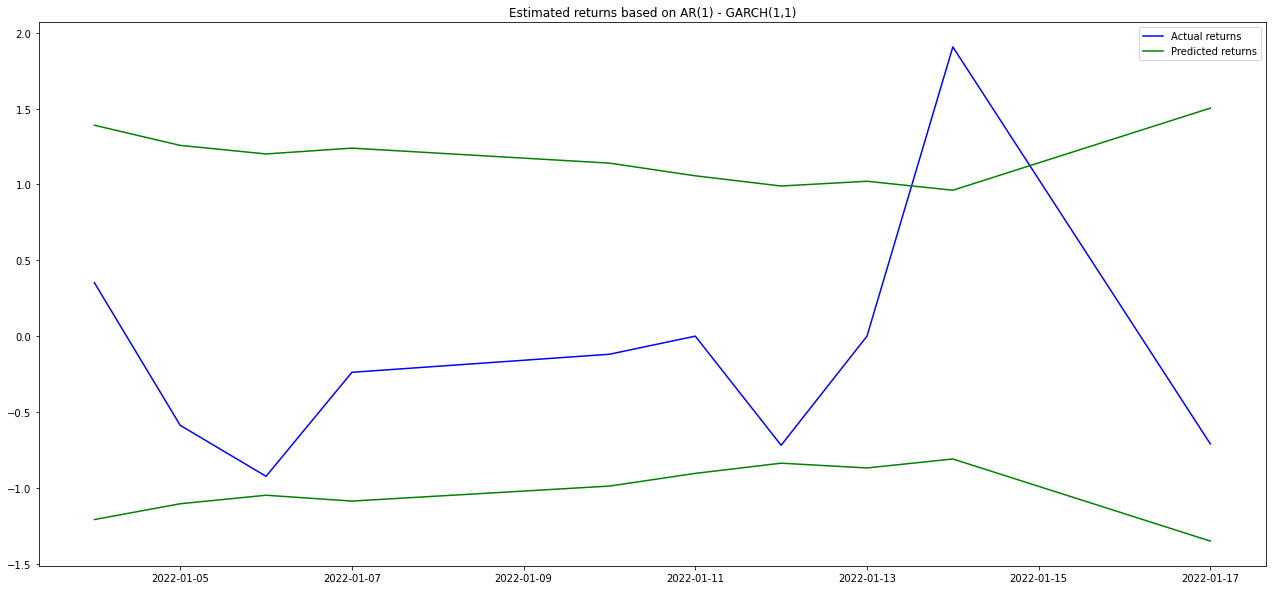

In [33]:
plt.figure(figsize = (22,10))
plt.plot(out_of_sample.index, out_of_sample['Log return %'], color = 'blue', label = 'Actual returns')
plt.plot(results_out_sample['Predicted upper returns'], color = 'green', label = 'Predicted returns')
plt.plot(results_out_sample['Predicted lower returns'], color = 'green')
plt.legend()
plt.title(f'Estimated returns based on AR(1) - GARCH(1,1)')
plt.show()

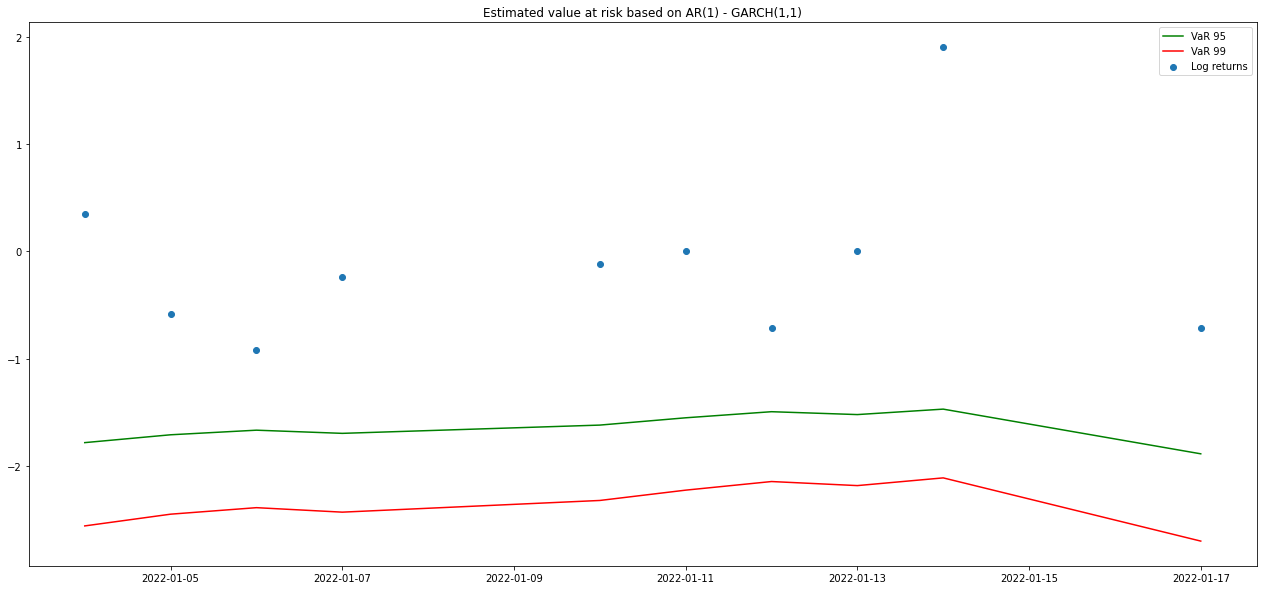

In [34]:
plt.figure(figsize = (22,10))
plt.scatter(out_of_sample.index, out_of_sample['Log return %'], label = 'Log returns')
plt.plot(results_out_sample['Estimated VaR 95'], color = 'green', label = 'VaR 95')
plt.plot(results_out_sample['Estimated VaR 99'], color = 'red', label = 'VaR 99')
plt.legend()
plt.title(f'Estimated value at risk based on AR(1) - GARCH(1,1)')
plt.show()

In [35]:
excess_VaR95_out = 0
excess_VaR99_out = 0

for i in out_of_sample.index:
  if results_out_sample.at[i, 'Estimated VaR 95'] > out_of_sample.at[i, 'Log return %']:
    excess_VaR95 += 1
  
  if results_out_sample.at[i, 'Estimated VaR 99'] > out_of_sample.at[i, 'Log return %']:
    excess_VaR99 += 1

In [36]:
print(f'Number of values that exceeds the estimated VaR 95: {excess_VaR95_out}\nNumber of values that exceeds the estimated VaR 99: {excess_VaR99_out}')

Number of values that exceeds the estimated VaR 95: 0
Number of values that exceeds the estimated VaR 99: 0


In [37]:
MSE_u_out = mean_squared_error(y_true = out_of_sample['Log return %'], y_pred = results_out_sample['Predicted upper returns'])
MSE_l_out = mean_squared_error(y_true = out_of_sample['Log return %'], y_pred = results_out_sample['Predicted lower returns'])

MAE_u_out = mean_absolute_error(y_true = out_of_sample['Log return %'], y_pred = results_out_sample['Predicted upper returns'])
MAE_l_out = mean_absolute_error(y_true = out_of_sample['Log return %'], y_pred = results_out_sample['Predicted lower returns'])

MAPE_u_out = mean_absolute_percentage_error(y_true = out_of_sample['Log return %'], y_pred = results_out_sample['Predicted upper returns'])
MAPE_l_out = mean_absolute_percentage_error(y_true = out_of_sample['Log return %'], y_pred = results_out_sample['Predicted lower returns'])

SMAPE_u_out = smape(y_true = out_of_sample['Log return %'], y_pred = results_out_sample['Predicted upper returns'])
SMAPE_l_out = smape(y_true = out_of_sample['Log return %'], y_pred = results_out_sample['Predicted lower returns'])

In [38]:
print(f'MSE of upper predictions: {MSE_u_out}\nMSE of lower predictions: {MSE_l_out}\nMAE of upper predictions: {MAE_u_out}\nMAE of lower predictions: {MAE_l_out}\nMAPE of upper predictions: {MAPE_u_out}\nMAPE of lower predictions: {MAPE_l_out}\nSMAPE of upper predictions: {SMAPE_u_out}\nSMAPE of lower predictions: {SMAPE_l_out}')

MSE of upper predictions: 2.3654843622774484
MSE of lower predictions: 1.357792401635052
MAE of upper predictions: 1.4695075673173696
MAE of lower predictions: 0.9171089760556427
MAPE of upper predictions: 936065441185730.2
MAPE of lower predictions: 798912301123134.2
SMAPE of upper predictions: 178.49986119270798
SMAPE of lower predictions: 123.59799153885936


# Rolling out-of-sample forecast

In [39]:
train_len = 500
test_len = 10
list_ = []
i=0

In [40]:
while train_len + test_len + i*test_len < len(VNM):
  train = VNM[i*test_len : train_len + i*test_len].copy()
  test = VNM[train_len + i*test_len : train_len + test_len + i*test_len].copy()

  #fit model
  arma = sm.tsa.ARIMA(train['Log return %'], order = (1,0,0))
  arma_results = arma.fit()

  #predict
  start = len(train)
  end = len(train) + len(test) - 1
  arma_predictions = pd.DataFrame()
  arma_predictions["Mean predictions"] = arma_results.predict(start = start, end = end, dynamic = False)
  arma_predictions.index = test.index

  ### GARCH
  resid_df = VNM.copy()
  resid_df["resid"] = resid_df["Log return %"].shift(1).loc[resid_df.index]
  resid_df.at[train.index[0]:train.index[-1], "resid"] = arma_results.resid

  resid_model = arch_model(resid_df["resid"][1:], p = 1, q = 1, vol = "GARCH", mean = 'Zero')
  resid_model_results = resid_model.fit(last_obs = test.index[0], update_freq = 5)

  resid_forecasts = resid_model_results.forecast().residual_variance.loc[test.index].values

  results = arma_predictions.copy()
  results['Standard deviation'] = np.sqrt(resid_forecasts)
  results['Predicted upper returns'] = results['Mean predictions'] + results['Standard deviation']**2
  results['Predicted lower returns'] = results['Mean predictions'] - results['Standard deviation']**2
  results['Estimated VaR 95'] = results['Mean predictions'] - results['Standard deviation']*norm.ppf(0.95)
  results['Estimated VaR 99'] = results['Mean predictions'] - results['Standard deviation']*norm.ppf(0.99)
  results['Actual returns'] = test['Log return %']
  list_.append(results)
  i += 1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-pac

Iteration:      5,   Func. Count:     32,   Neg. LLF: 840.7642990810155
Iteration:     10,   Func. Count:     57,   Neg. LLF: 840.7189493847006
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 840.7189493845848
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     32,   Neg. LLF: 860.8204140244334
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 860.8002405973857
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     32,   Neg. LLF: 874.0609614399336
Iteration:     10,   Func. Count:     57,   Neg. LLF: 873.9914882714754
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 873.9914882713648
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     32,   Neg. LLF: 890.2378304952526
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 890.1722178509491
            Iterations: 9
            Function evaluations: 53
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     35,   Neg. LLF: 916.8299420529644
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 916.8155247061969
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     30,   Neg. LLF: 932.9083370865934
Iteration:     10,   Func. Count:     59,   Neg. LLF: 931.9458899822665
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 931.9455335830434
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11
Iteration:      5,   Func. Count:     35,   Neg. LLF: 956.0805164412016
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 956.079002612193
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     35,   Neg. LLF: 969.2797850561174
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 969.2767860980371
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-pac

Iteration:      5,   Func. Count:     35,   Neg. LLF: 980.3473625136054
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 980.3388781156883
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-pac

Iteration:      5,   Func. Count:     35,   Neg. LLF: 990.9289864774723
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 990.9226362117695
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


Iteration:      5,   Func. Count:     35,   Neg. LLF: 1004.7423875027173
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1004.7369637994916
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     35,   Neg. LLF: 1018.1408754732478
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1018.1374876278013
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1031.7273913303861
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1031.725648881442
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     35,   Neg. LLF: 1044.5743735777141
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1044.5730915994595
            Iterations: 7
            Function evaluations: 45
            Gradient evaluations: 7


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     35,   Neg. LLF: 1056.9667733179317
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1056.9650806295765
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1087.7410177329177
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1086.4781808750813
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1086.4751259821014
            Iterations: 13
            Function evaluations: 73
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1113.2671747279892
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1113.2469004111515
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     35,   Neg. LLF: 1133.125955329614
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1133.1048902192124
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     35,   Neg. LLF: 1153.9902138526663
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1153.9801348497479
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1171.3790207078207
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1171.3691021917284
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     35,   Neg. LLF: 1194.7997322398865
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1194.793729194502
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1221.3875437100733
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1221.378093954609
            Iterations: 8
            Function evaluations: 51
            Gradient evaluations: 8


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     35,   Neg. LLF: 1241.433654148308
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1241.427336820479
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1255.7853864677354
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1255.7728119371072
            Iterations: 8
            Function evaluations: 51
            Gradient evaluations: 8


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     35,   Neg. LLF: 1270.795858781657
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1270.7827010074848
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     35,   Neg. LLF: 1290.3193909937233
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1290.3078331963277
            Iterations: 8
            Function evaluations: 51
            Gradient evaluations: 8
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1317.3305215425257


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1317.3130518037688
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


Iteration:      5,   Func. Count:     35,   Neg. LLF: 1341.8111240270248
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1341.8044472258773
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     35,   Neg. LLF: 1363.1522409787824
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1363.14624257626
            Iterations: 8
            Function evaluations: 51
            Gradient evaluations: 8
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1374.6860457309726
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1374.6743017090407
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     35,   Neg. LLF: 1398.3618769743543
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1398.3559841383144
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1419.3597923223267
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1419.3548738470752
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     35,   Neg. LLF: 1444.634391520463
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1444.6284730518264
            Iterations: 8
            Function evaluations: 51
            Gradient evaluations: 8


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     35,   Neg. LLF: 1462.732702379659
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1462.724715248669
            Iterations: 8
            Function evaluations: 51
            Gradient evaluations: 8
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1474.6417952803317
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1474.6290962370126
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     35,   Neg. LLF: 1490.432731851423
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1490.417273306141
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1511.2909373754876
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1511.2782869443897
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     35,   Neg. LLF: 1529.6872512424898
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1529.6770420762468
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1545.0203251517657
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1545.0140087946875
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     36,   Neg. LLF: 1563.7854787303497
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1563.7558443165476
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     36,   Neg. LLF: 1578.5026188226916
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1578.4735493557605
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1605.653046897108
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1605.6133411946262
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     36,   Neg. LLF: 1625.9023003000698
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1625.851848602797
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     36,   Neg. LLF: 1639.7914012470717
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1639.7244888774126
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      5,   Func. Count:     36,   Neg. LLF: 1653.7805824023496
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1653.7099263646849
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


Iteration:      5,   Func. Count:     35,   Neg. LLF: 1664.6385691281396
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1664.6243790725857
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     35,   Neg. LLF: 1675.3004536237056
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1675.2840869308272
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1686.3639774697863
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1686.3454644278784
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     35,   Neg. LLF: 1700.5230481876285
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1700.512770685276
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1712.5941235253606
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1712.5824135285245
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     35,   Neg. LLF: 1722.166372833667
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1722.155162589143
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1735.8161398753111
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1735.803381369135


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1749.8263054347399
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1749.8151449270308
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     35,   Neg. LLF: 1760.3346711697866
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1760.3190342690052
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1774.6175623607287
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1774.6084714247181
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     36,   Neg. LLF: 1797.5071068562484
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1797.4673978418907
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1814.2593190717078
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1814.2244843753988
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     36,   Neg. LLF: 1827.174506420101
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1827.1365984234935
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     36,   Neg. LLF: 1859.6877193704947
Iteration:     10,   Func. Count:     61,   Neg. LLF: 1859.6177489959964
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1859.617748995707
            Iterations: 10
            Function evaluations: 61
            Gradient evaluations: 10


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     36,   Neg. LLF: 1877.880591010575
Iteration:     10,   Func. Count:     61,   Neg. LLF: 1877.8056403390221
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1877.8056403387868
            Iterations: 10
            Function evaluations: 61
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     29,   Neg. LLF: 1891.6420430153823
Iteration:     10,   Func. Count:     57,   Neg. LLF: 1890.5337571161558
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1890.533708967041
            Iterations: 11
            Function evaluations: 63
            Gradient evaluations: 11


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     29,   Neg. LLF: 1905.0158135004278
Iteration:     10,   Func. Count:     57,   Neg. LLF: 1903.6935211861562
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1903.693492941188
            Iterations: 12
            Function evaluations: 67
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


Iteration:      5,   Func. Count:     29,   Neg. LLF: 1921.0353206334994
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1920.0512976990674
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1920.051290575735
            Iterations: 11
            Function evaluations: 63
            Gradient evaluations: 11


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     29,   Neg. LLF: 1940.4768551608156
Iteration:     10,   Func. Count:     55,   Neg. LLF: 1939.6439343480265
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1939.6437991612154
            Iterations: 11
            Function evaluations: 60
            Gradient evaluations: 11


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     29,   Neg. LLF: 1957.2954988415756
Iteration:     10,   Func. Count:     55,   Neg. LLF: 1956.590063095141
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1956.5899185019575
            Iterations: 12
            Function evaluations: 65
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     29,   Neg. LLF: 1971.080947690574
Iteration:     10,   Func. Count:     56,   Neg. LLF: 1970.2298409018351
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1970.2278043976758
            Iterations: 13
            Function evaluations: 71
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     29,   Neg. LLF: 1984.9156164839808
Iteration:     10,   Func. Count:     56,   Neg. LLF: 1984.0050400674063
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1984.003690580876
            Iterations: 13
            Function evaluations: 71
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     29,   Neg. LLF: 1997.141654302875
Iteration:     10,   Func. Count:     56,   Neg. LLF: 1996.28007046419
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1996.280064325917
            Iterations: 11
            Function evaluations: 61
            Gradient evaluations: 11


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     29,   Neg. LLF: 2011.9383190203143
Iteration:     10,   Func. Count:     57,   Neg. LLF: 2011.194750363221
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2011.1947503635595
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     29,   Neg. LLF: 2032.3548292265996
Iteration:     10,   Func. Count:     55,   Neg. LLF: 2031.6167586294632
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2031.6165392458881
            Iterations: 13
            Function evaluations: 70
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      5,   Func. Count:     29,   Neg. LLF: 2048.3302568913173
Iteration:     10,   Func. Count:     57,   Neg. LLF: 2047.5626433899358
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2047.5626417979272
            Iterations: 11
            Function evaluations: 62
            Gradient evaluations: 11


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-pac

Iteration:      5,   Func. Count:     29,   Neg. LLF: 2059.2872489518495
Iteration:     10,   Func. Count:     56,   Neg. LLF: 2058.37045981714
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2058.369915796357
            Iterations: 13
            Function evaluations: 71
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-pac

Iteration:      5,   Func. Count:     29,   Neg. LLF: 2072.3227093074815
Iteration:     10,   Func. Count:     57,   Neg. LLF: 2071.7318984577996
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2071.731898457624
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     29,   Neg. LLF: 2084.276880437017


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-pac

Iteration:     10,   Func. Count:     57,   Neg. LLF: 2083.7222182490254
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2083.7222182488695
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2112.7040208526982
Iteration:     10,   Func. Count:     61,   Neg. LLF: 2111.663222302632
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2111.6631611825514


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-pac

            Iterations: 11
            Function evaluations: 66
            Gradient evaluations: 11


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


Iteration:      5,   Func. Count:     32,   Neg. LLF: 2133.353646159944
Iteration:     10,   Func. Count:     61,   Neg. LLF: 2132.340790923561
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2132.3405319763287
            Iterations: 11
            Function evaluations: 66
            Gradient evaluations: 11


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 2149.899345342485
Iteration:     10,   Func. Count:     59,   Neg. LLF: 2149.0574460164216
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2149.0573127615976
            Iterations: 12
            Function evaluations: 69
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-pac

Iteration:      5,   Func. Count:     32,   Neg. LLF: 2171.816601400091
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2170.9451319686787
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2170.9446911554805
            Iterations: 13
            Function evaluations: 75
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     32,   Neg. LLF: 2186.579473508592
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2185.678277462926
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2185.67396023715
            Iterations: 13
            Function evaluations: 75
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     32,   Neg. LLF: 2201.604419909395
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2200.7112717256823
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2200.7084568443997
            Iterations: 13
            Function evaluations: 75
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     32,   Neg. LLF: 2211.0540232106705
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2210.142875115529
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2210.139505051206
            Iterations: 13
            Function evaluations: 75
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2229.2724614816966
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2228.3297200805373
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2228.3259305372035
            Iterations: 13
            Function evaluations: 75
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2242.04354494733
Iteration:     10,   Func. Count:     61,   Neg. LLF: 2241.127036656961


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2241.1264498734427
            Iterations: 11
            Function evaluations: 66
            Gradient evaluations: 11
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2254.4126915376046
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2253.5730740745403
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2253.569892819579
            Iterations: 13
            Function evaluations: 75
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 2266.279070754247
Iteration:     10,   Func. Count:     61,   Neg. LLF: 2265.3661982019557
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2265.3651539840776
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 11


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     32,   Neg. LLF: 2279.177280790601
Iteration:     10,   Func. Count:     61,   Neg. LLF: 2278.2540922606404
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2278.252454244459
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2303.8762334717685
Iteration:     10,   Func. Count:     61,   Neg. LLF: 2302.922934798606
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2302.922896675872
            Iterations: 11
            Function evaluations: 66
            Gradient evaluations: 11
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2319.390741724482
Iteration:     10,   Func. Count:     61,   Neg. LLF: 2318.48051798806
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2318.479617570183
            Iterations: 11
           

/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 2335.9522029127284
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2335.05789933672
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2335.0565098363495
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 2352.9601104272906
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2352.069134483165
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2352.069041116193
            Iterations: 12
            Function evaluations: 70
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 2380.4453490236
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2379.7748597175173
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2379.7748184711063
            Iterations: 11
            Function evaluations: 65
            Gradient evaluations: 11


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 2404.80018764919
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2403.8527347521776
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2403.8527061257537
            Iterations: 12
            Function evaluations: 70
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     32,   Neg. LLF: 2421.9962420885927
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2421.470069439266
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2421.470069003888
            Iterations: 10
            Function evaluations: 61
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2443.349339411002
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2442.5444792252692
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2442.5444102694723
            Iterations: 12
            Function evaluations: 70
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2466.20048725447
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2465.2226876599343


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2465.2225751906603
            Iterations: 12
            Function evaluations: 70
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2488.2109099727622
Iteration:     10,   Func. Count:     61,   Neg. LLF: 2486.9209871644443
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2486.917970591306
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-pac

Iteration:      5,   Func. Count:     32,   Neg. LLF: 2513.7774687071706
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2512.225327945644
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2512.2251779984617
            Iterations: 12
            Function evaluations: 70
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2536.255010075409
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2534.7184119265467
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2534.7181451433535
            Iterations: 12
            Function evaluations: 70
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 2556.496298925416
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2554.8618950829914
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2554.8618743979387
            Iterations: 12
            Function evaluations: 70
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-pac

Iteration:      5,   Func. Count:     32,   Neg. LLF: 2574.09084159107
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2572.3756834532505
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2572.3756588353363
            Iterations: 11
            Function evaluations: 65
            Gradient evaluations: 11
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2589.7880712011984
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2588.0547606590917
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2588.054726913647
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     32,   Neg. LLF: 2610.6757038373107
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2608.901802345161
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2608.901535690879
            Iterations: 12
            Function evaluations: 70
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2629.742163143021
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2628.00289408144
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2628.002625346731
            Iterations: 12
            Function evaluations: 70
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 2645.391309277967
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2643.7304796707817
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2643.7304503716214
            Iterations: 11
            Function evaluations: 66
            Gradient evaluations: 11


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      5,   Func. Count:     31,   Neg. LLF: 2664.85154754581
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2662.7814618895245
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2662.780765372303
            Iterations: 13
            Function evaluations: 75
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


Iteration:      5,   Func. Count:     31,   Neg. LLF: 2680.0746105610147
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2677.9501332070163
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2677.949319872162
            Iterations: 13
            Function evaluations: 75
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     31,   Neg. LLF: 2698.1835287507656
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2695.9900208840727
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2695.988697495899
            Iterations: 13
            Function evaluations: 75
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 2716.9321749729374
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2714.6375767412883
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2714.6364290872325
            Iterations: 13
            Function evaluations: 75
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2729.8502362777667
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2728.05683402439
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2727.9788748453216
            Iterations: 14
            Function evaluations: 80
            Gradient evaluations: 14


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 2747.6830111499917
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2745.4935911831244
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2745.4926382287986
            Iterations: 13
            Function evaluations: 75
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     31,   Neg. LLF: 2762.976712361077
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2760.5097109231656
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2760.507360498541
            Iterations: 13

/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro


            Function evaluations: 75
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


Iteration:      5,   Func. Count:     31,   Neg. LLF: 2775.71300541063
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2773.3867181259347
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2773.385550544699
            Iterations: 13
            Function evaluations: 75
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2792.6524177249607


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:     10,   Func. Count:     61,   Neg. LLF: 2790.9093119533227
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2790.8954092744725
            Iterations: 13
            Function evaluations: 76
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 2805.2787919136044
Iteration:     10,   Func. Count:     62,   Neg. LLF: 2803.3203914187015
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2803.320236092996
            Iterations: 12
            Function evaluations: 72
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 2828.6028317896057
Iteration:     10,   Func. Count:     61,   Neg. LLF: 2826.9247963323933
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2826.910950365394
            Iterations: 13
            Function evaluations: 76
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2847.6065686867637


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:     10,   Func. Count:     61,   Neg. LLF: 2845.9053705417937
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2845.890350021954
            Iterations: 12
            Function evaluations: 72
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2867.9883619526227
Iteration:     10,   Func. Count:     62,   Neg. LLF: 2866.177038441366
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2866.17684254745
            Iterations: 12
            Function evaluations: 72
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2890.6349625544426
Iteration:     10,   Func. Count:     62,   Neg. LLF: 2888.6238145276625
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2888.6234387172567
            Iterations: 12
            Function evaluations: 72
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 2905.0320547833835
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2902.64253878232
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2902.642527368764
            Iterations: 11
            Function evaluations: 65
            Gradient evaluations: 11
Iteration:      5,   Func. Count:     31,   Neg. LLF: 2917.92856627484
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2915.5733983774985
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2915.573362904227
            Iterations: 12
            Function evaluations: 70
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 2933.431266659396
Iteration:     10,   Func. Count:     61,   Neg. LLF: 2931.68414773776
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2931.667281073496
            Iterations: 13
            Function evaluations: 76
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 2946.579341349591
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2944.1902210024737
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2944.1901909025546
            Iterations: 12
            Function evaluations: 70
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 2965.6240627927064
Iteration:     10,   Func. Count:     59,   Neg. LLF: 2963.6612950865174
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2963.65427218031
            Iterations: 13
            Function evaluations: 75
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 2984.8934215439594
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2983.1942678305454
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2983.1917980876856
            Iterations: 13
            Function evaluations: 75
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 3006.166643284514
Iteration:     10,   Func. Count:     59,   Neg. LLF: 3004.1408484767935
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3004.1359165465924
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 3017.388146253771
Iteration:     10,   Func. Count:     59,   Neg. LLF: 3015.6992694763594
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3015.697242648167
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 3032.8304832900985
Iteration:     10,   Func. Count:     59,   Neg. LLF: 3031.2450207652273
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3031.2439520214375
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     31,   Neg. LLF: 3049.52537445843
Iteration:     10,   Func. Count:     59,   Neg. LLF: 3048.005293273608
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3048.003397996437
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     31,   Neg. LLF: 3061.7024301841393
Iteration:     10,   Func. Count:     59,   Neg. LLF: 3060.1012654411006
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3060.0994201031563
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Iteration:      5,   Func. Count:     31,   Neg. LLF: 3072.643799142529
Iteration:     10,   Func. Count:     59,   Neg. LLF: 3070.902434790298
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3070.900894721732
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


Iteration:      5,   Func. Count:     31,   Neg. LLF: 3088.476321325183
Iteration:     10,   Func. Count:     59,   Neg. LLF: 3086.7432879464095
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3086.7413649750847
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3099.4548109708467
Iteration:     10,   Func. Count:     59,   Neg. LLF: 3097.6343757007076


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3097.6326511409957
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 3112.5181717395994
Iteration:     10,   Func. Count:     59,   Neg. LLF: 3110.627461303915
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3110.625505332931
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 3126.9280676497833
Iteration:     10,   Func. Count:     59,   Neg. LLF: 3125.0086602176707
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3125.00657947201
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3142.2895489524426


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:     10,   Func. Count:     59,   Neg. LLF: 3140.34257032653
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3140.340067029104
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 3155.4952601639457
Iteration:     10,   Func. Count:     59,   Neg. LLF: 3153.6395550524985
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3153.6364211824484
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 3166.6018138562295
Iteration:     10,   Func. Count:     59,   Neg. LLF: 3164.5647065641697
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3164.5621797080303
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 3182.8010732204602
Iteration:     10,   Func. Count:     59,   Neg. LLF: 3180.7643990866964
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3180.761908828895
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3198.9391326536233
Iteration:     10,   Func. Count:     59,   Neg. LLF: 3196.83598607393
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3196.8330491643756
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 3211.6535113489454
Iteration:     10,   Func. Count:     59,   Neg. LLF: 3209.405358337396
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3209.400828532719
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     31,   Neg. LLF: 3221.624457330132
Iteration:     10,   Func. Count:     59,   Neg. LLF: 3219.7359819309117
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3219.7344159524782
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3233.418050512353
Iteration:     10,   Func. Count:     59,   Neg. LLF: 3231.369929096968
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3231.3679130573028
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3245.37531374421
Iteration:     10,   Func. Count:     59,   Neg. LLF: 3243.252928946027
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3243.2507029058056
            Iterations: 13
         

/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 3252.6671029079043
Iteration:     10,   Func. Count:     61,   Neg. LLF: 3250.6189071295566
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3250.61863718527
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3260.2072414846843
Iteration:     10,   Func. Count:     62,   Neg. LLF: 3258.008155119775
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3258.008016654605
            Iterations: 12
            Function evaluations: 72
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     35,   Neg. LLF: 3270.23578736733
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3270.210980626224
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 3306.025088484499
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3304.6400655727384
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3304.6365308698314
            Iterations: 12
            Function evaluations: 73
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 3326.258542687917
Iteration:     10,   Func. Count:     61,   Neg. LLF: 3324.47774341925
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3324.4772494142685
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3354.130230199225
Iteration:     10,   Func. Count:     61,   Neg. LLF: 3351.2697530493037
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3351.2668454667696
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 11


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     32,   Neg. LLF: 3373.5374132605734
Iteration:     10,   Func. Count:     61,   Neg. LLF: 3370.8161288723477
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3370.8111600539623
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3390.934834320161
Iteration:     10,   Func. Count:     61,   Neg. LLF: 3388.2583792255646
Optimization terminated successfully.    (Exit mode 0)


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

            Current function value: 3388.2515181256704
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


Iteration:      5,   Func. Count:     32,   Neg. LLF: 3412.1771783119357
Iteration:     10,   Func. Count:     61,   Neg. LLF: 3409.3149782815253
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3409.3028190176765
            Iterations: 13
            Function evaluations: 76
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 3433.775481197296
Iteration:     10,   Func. Count:     61,   Neg. LLF: 3430.8854635965026
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3430.879831754462
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3456.149065322141
Iteration:     10,   Func. Count:     61,   Neg. LLF: 3453.1103195985806
Optimization terminated successfully.    (Exit mode 0)


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

            Current function value: 3453.1051502471537
            Iterations: 12
            Function evaluations: 72
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3474.4024031531717


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-pac

Iteration:     10,   Func. Count:     61,   Neg. LLF: 3471.3736590081376
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3471.3651391733065
            Iterations: 13
            Function evaluations: 76
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


Iteration:      5,   Func. Count:     32,   Neg. LLF: 3491.4022895762564
Iteration:     10,   Func. Count:     61,   Neg. LLF: 3488.380992567488
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3488.3689902991
            Iterations: 13
            Function evaluations: 76
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3511.358804702312


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:     10,   Func. Count:     61,   Neg. LLF: 3508.4256878785914
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3508.421955657117
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 11


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     36,   Neg. LLF: 3528.5126739573107
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3528.4906939194934
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     36,   Neg. LLF: 3549.367597944418
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3549.347375001438
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3574.048762892801
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3574.022640264883
            Iterations: 8
            Function evaluations: 52
            Gradient evaluations: 8


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     36,   Neg. LLF: 3594.7348814984284
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3594.7028442629717
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     36,   Neg. LLF: 3618.0392483526693
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3618.012952278819
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     36,   Neg. LLF: 3637.125504835399
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3637.0907839649817
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3650.070230085275


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3650.016719404196
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3671.02749920475
Iteration:     10,   Func. Count:     61,   Neg. LLF: 3670.993667406703


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-pac

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3670.9936674066566
            Iterations: 10
            Function evaluations: 61
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3687.3656211622283


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-pac

Iteration:     10,   Func. Count:     61,   Neg. LLF: 3687.328159815013
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3687.328159815406
            Iterations: 10
            Function evaluations: 61
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3703.1757326050715


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-pac

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3703.142630765135
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3728.9575921713367
Iteration:     10,   Func. Count:     61,   Neg. LLF: 3725.846210101493
Optimization terminated successfully.    (Exit mode 0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-pac


            Current function value: 3725.841799893261
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3743.8755907747736
Iteration:     10,   Func. Count:     61,   Neg. LLF: 3740.8800912959778
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3740.8723399477467
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     32,   Neg. LLF: 3761.101140836322
Iteration:     10,   Func. Count:     61,   Neg. LLF: 3758.109690983434
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3758.1035029983987
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3779.2604130824257
Iteration:     10,   Func. Count:     61,   Neg. LLF: 3776.2867497719635
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3776.2814915907175
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3799.0331980226583
Iteration:     10,   Func. Count:     61,   Neg. LLF: 3796.046105531861
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3796.03662725127
            Iterations: 12
        

/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 3819.274765218925
Iteration:     10,   Func. Count:     61,   Neg. LLF: 3815.8285314393397
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3815.828234449279
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3842.1833319355765


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:     10,   Func. Count:     61,   Neg. LLF: 3839.111154453728
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3839.102111593007
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3861.539566691771
Iteration:     10,   Func. Count:     61,   Neg. LLF: 3858.497864031633
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3858.4858899132764
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3885.5142045390985
Iteration:     10,   Func. Count:     61,   Neg. LLF: 3882.319622784804
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3882.3018803937525
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 3899.341735626622
Iteration:     10,   Func. Count:     61,   Neg. LLF: 3896.462542510454
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3896.454044690736
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     32,   Neg. LLF: 3911.124952988612
Iteration:     10,   Func. Count:     61,   Neg. LLF: 3908.3332289717428
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3908.3320613993715
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     32,   Neg. LLF: 3937.3389022483816
Iteration:     10,   Func. Count:     60,   Neg. LLF: 3936.3184104325755
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3936.3183992703225
            Iterations: 11
            Function evaluations: 66
            Gradient evaluations: 11
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3953.2288080885487
Iteration:     10,   Func. Count:     60,   Neg. LLF: 3952.2202534543976
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3952.220253134049
            Iterations: 10
            Function evaluations: 61
            Gradient evaluations: 10


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 3967.3351977240527
Iteration:     10,   Func. Count:     60,   Neg. LLF: 3966.325620678205
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3966.3256141265533
            Iterations: 11
            Function evaluations: 65
            Gradient evaluations: 11
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3985.2590515654465
Iteration:     10,   Func. Count:     59,   Neg. LLF: 3982.895225870783
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3982.892120515863
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     31,   Neg. LLF: 4002.6620011198665
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4000.431253621992
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4000.4298866629024
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4019.6516920948475
Iteration:     10,   Func. Count:     58,   Neg. LLF: 4017.3919951670364
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4017.389715061113
            Iterations: 13
            Function evaluations: 73
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 4038.7620485895436
Iteration:     10,   Func. Count:     58,   Neg. LLF: 4036.3997694084064
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4036.3962609800283
            Iterations: 13
            Function evaluations: 73
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4053.94201939329
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4051.563431174797
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4051.563428672576
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     31,   Neg. LLF: 4067.7295202489504
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4065.346876333878
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4065.3468703372596
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4078.5414298645437
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4076.0386830898774
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4076.038249290228
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associat

Iteration:      5,   Func. Count:     31,   Neg. LLF: 4094.5753804708397
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4092.089262415965
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4092.0892593046797
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4107.505382562949
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4104.984069100638
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4104.9840649942425
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4124.761407984298
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4122.332859850359
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4122.332828305851
            Iterations: 12
         

/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 4156.471473878867
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4154.0199171705935
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4154.019842571703
            Iterations: 12
            Function evaluations: 69
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4175.214779070939
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4172.802654933443
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4172.802607058585
            Iterations: 12
            Function evaluations: 69
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 4188.788479243039
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4186.378473614526
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4186.378311268516
            Iterations: 12
            Function evaluations: 69
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4203.851702388242
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4201.423635633768
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4201.423573572248
            Iterations: 12
            Function evaluations: 69
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 4217.069730172176
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4214.38025654008
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4214.380069661305
            Iterations: 12
            Function evaluations: 70
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4236.06726059258
Iteration:     10,   Func. Count:     61,   Neg. LLF: 4233.690025759112
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4233.690021287466
            Iterations: 11
            Function evaluations: 66
            Gradient evaluations: 11


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 4254.439588828929
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4251.937430140123
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4251.937424606298
            Iterations: 11
            Function evaluations: 65
            Gradient evaluations: 11
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4268.966549486124
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4266.443511003387
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4266.443501941192
            Iterations: 12
            Function evaluations: 69
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4281.953467424544


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:     10,   Func. Count:     59,   Neg. LLF: 4279.375491123637
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4279.375475408657
            Iterations: 12
            Function evaluations: 69
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4308.876457036493
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4306.911147359853
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4306.907293604289
            Iterations: 13
            Function evaluations: 72
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4328.018402443371

/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro


Iteration:     10,   Func. Count:     59,   Neg. LLF: 4326.133095571246
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4326.13309051972
            Iterations: 12
            Function evaluations: 69
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4349.211834070761
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4347.370295462124
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4347.368715207138
            Iterations: 13
            Function evaluations: 72
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4382.753332025703


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:     10,   Func. Count:     59,   Neg. LLF: 4379.393347587682
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4379.393150401103
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4413.899634240726
Iteration:     10,   Func. Count:     60,   Neg. LLF: 4410.47933827897
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4410.448573746741
            Iterations: 14
            Function evaluations: 80
            Gradient evaluations: 14
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4433.331001881182


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:     10,   Func. Count:     60,   Neg. LLF: 4430.49818438375
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4430.497561510327
            Iterations: 12
            Function evaluations: 70
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4461.82024758702
Iteration:     10,   Func. Count:     60,   Neg. LLF: 4458.258797983381
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4458.25243070135
            Iterations: 12
            Function evaluations: 70
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 4485.23060637846
Iteration:     10,   Func. Count:     60,   Neg. LLF: 4481.663674851296
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4481.632177587668
            Iterations: 13
            Function evaluations: 75
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4503.608971916117
Iteration:     10,   Func. Count:     60,   Neg. LLF: 4500.0727200821075
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4500.053245911273
            Iterations: 13
            Function evaluations: 75
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 4521.740670243196
Iteration:     10,   Func. Count:     60,   Neg. LLF: 4518.2766775626715
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4518.254597403967
            Iterations: 13
            Function evaluations: 75
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4546.505938838189
Iteration:     10,   Func. Count:     60,   Neg. LLF: 4543.383377991571
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4543.374582087903
            Iterations: 13
            Function evaluations: 75
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4564.585194582072


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:     10,   Func. Count:     60,   Neg. LLF: 4561.461165772633
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4561.445364690641
            Iterations: 13
            Function evaluations: 76
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4577.864184227997
Iteration:     10,   Func. Count:     60,   Neg. LLF: 4574.841609184212
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4574.834504110193
            Iterations: 13
            Function evaluations: 75
            Gradient evaluations: 13


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 4606.724000383913
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4605.071813601937
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4605.07172833647
            Iterations: 12
            Function evaluations: 69
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     32,   Neg. LLF: 4627.753679238311
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4626.229421471738
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4626.229404342337
            Iterations: 12
            Function evaluations: 69
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 4643.726247366039
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4641.468333953454
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4641.468331014122
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11
Iteration:      5,   Func. Count:     32,   Neg. LLF: 4657.302882247405
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4655.805802392785
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4655.805780601353
            Iterations: 12
            Function evaluations: 69
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 4679.760795517379
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4677.591915603255
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4677.591912001217
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11
Iteration:      5,   Func. Count:     32,   Neg. LLF: 4690.8100091217875
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4688.986142323236
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4688.986132665379
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 4708.912590548877
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4707.091315113104
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4707.091313792134
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4720.463469318889
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4718.522318230385
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4718.522317563548
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 4733.260667509911
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4731.298154571874
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4731.298153818884
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4749.187752717004
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4747.091129919108
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4747.091127344764
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 4763.164658179457
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4761.075558811809
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4761.075556331185
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11
Iteration:      5,   Func. Count:     32,   Neg. LLF: 4780.892374642728
Iteration:     10,   Func. Count:     60,   Neg. LLF: 4778.98009661536
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4778.980096616237
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     31,   Neg. LLF: 4804.69202930308
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4803.228805037483
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4803.228031974346
            Iterations: 13
            Function evaluations: 75
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     32,   Neg. LLF: 4837.377161874079
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4835.344883980156
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4835.344867605974
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 4854.066344205974
Iteration:     10,   Func. Count:     60,   Neg. LLF: 4852.692349935382
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4852.692349936721
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     33,   Neg. LLF: 4868.562356729339
Iteration:     10,   Func. Count:     60,   Neg. LLF: 4867.332238515319
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4867.332237194059
            Iterations: 11
            Function evaluations: 65
            Gradient evaluations: 11


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 4884.660943422961
Iteration:     10,   Func. Count:     58,   Neg. LLF: 4883.296682408761
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4883.296625183454
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11
Iteration:      5,   Func. Count:     32,   Neg. LLF: 4901.0000449705785
Iteration:     10,   Func. Count:     58,   Neg. LLF: 4899.676476993908
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4899.676422893988
            Iterations: 11
            Function evaluations: 63
            Gradient evaluations: 11


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 4922.279857818128
Iteration:     10,   Func. Count:     58,   Neg. LLF: 4920.95265361214
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4920.952598218279
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11
Iteration:      5,   Func. Count:     32,   Neg. LLF: 4948.733216839725
Iteration:     10,   Func. Count:     58,   Neg. LLF: 4947.418817220558
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4947.4188107796945
            Iterations: 11
            Function evaluations: 63
            Gradient evaluations: 11


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 4966.5240214638925
Iteration:     10,   Func. Count:     58,   Neg. LLF: 4965.2961805812665
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4965.296164127627
            Iterations: 11
            Function evaluations: 63
            Gradient evaluations: 11
Iteration:      5,   Func. Count:     32,   Neg. LLF: 4982.742081199186
Iteration:     10,   Func. Count:     58,   Neg. LLF: 4981.679956422143
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4981.679954709137
            Iterations: 11
            Function evaluations: 63
            Gradient evaluations: 11


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 4999.678302921405
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4998.510849239561
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4998.510849241524
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     32,   Neg. LLF: 5019.230165773167
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5018.0085995057925
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 5036.276051821311
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5035.018657661785
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
Iteration:      5,   Func. Count:     32,   Neg. LLF: 5049.565634979829
Iteration:     10,   Func. Count:     59,   Neg. LLF: 5048.42363038552
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5048.423630386527
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 5063.694644028855
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5062.521362308133
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 9
Iteration:      5,   Func. Count:     32,   Neg. LLF: 5080.423295499625
Iteration:     10,   Func. Count:     58,   Neg. LLF: 5079.187495285533
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5079.187410435476
            Iterations: 12
            Function evaluations: 68
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 5095.767219428581
Iteration:     10,   Func. Count:     58,   Neg. LLF: 5094.490939894302
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5094.490824032915
            Iterations: 12
            Function evaluations: 68
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     32,   Neg. LLF: 5112.879158742648
Iteration:     10,   Func. Count:     58,   Neg. LLF: 5111.659215763557
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5111.65915892006
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 5122.804902791508
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5121.610562541846
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 9
Iteration:      5,   Func. Count:     32,   Neg. LLF: 5134.324807988141
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5133.117852512565
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 5147.4005888087595
Iteration:     10,   Func. Count:     58,   Neg. LLF: 5146.1438243841485
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5146.143742100887
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11
Iteration:      5,   Func. Count:     32,   Neg. LLF: 5163.340734236623
Iteration:     10,   Func. Count:     58,   Neg. LLF: 5162.061323293175
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5162.061225218274
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

Iteration:      5,   Func. Count:     32,   Neg. LLF: 5177.151807569978
Iteration:     10,   Func. Count:     58,   Neg. LLF: 5175.7896049962
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5175.789382721838
            Iterations: 12
            Function evaluations: 68
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     32,   Neg. LLF: 5188.8379115579
Iteration:     10,   Func. Count:     58,   Neg. LLF: 5187.527964966768
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5187.52785892151
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been pro

In [41]:
roll_results = pd.DataFrame()
for i in list_:
  roll_results = roll_results.append(i)

roll_results

,Mean predictions,Standard deviation,Predicted upper returns,Predicted lower returns,Estimated VaR 95,Estimated VaR 99,Actual returns
2012-01-05,-0.260269,1.748130,2.795689,-3.316226,-3.135686,-4.327027,-3.699233
2012-01-06,0.059801,2.119316,4.551303,-4.431701,-3.426165,-4.870467,1.270495
2012-01-09,0.106919,1.994811,4.086189,-3.872350,-3.174252,-4.533704,0.596226
2012-01-10,0.113856,1.840125,3.499915,-3.272204,-2.912880,-4.166915,0.000000
2012-01-11,0.114877,1.689006,2.967618,-2.737865,-2.663291,-3.814339,0.000000
...,...,...,...,...,...,...,...
2022-01-05,-0.013279,1.022107,1.031424,-1.057982,-1.694496,-2.391056,-0.588029
2022-01-06,-0.013279,1.010115,1.007054,-1.033612,-1.674771,-2.363159,-0.924287
2022-01-07,-0.013279,1.040724,1.069826,-1.096385,-1.725117,-2.434364,-0.238379
2022-01-10,-0.013279,1.001880,0.990484,-1.017042,-1.661225,-2.344000,-0.119403


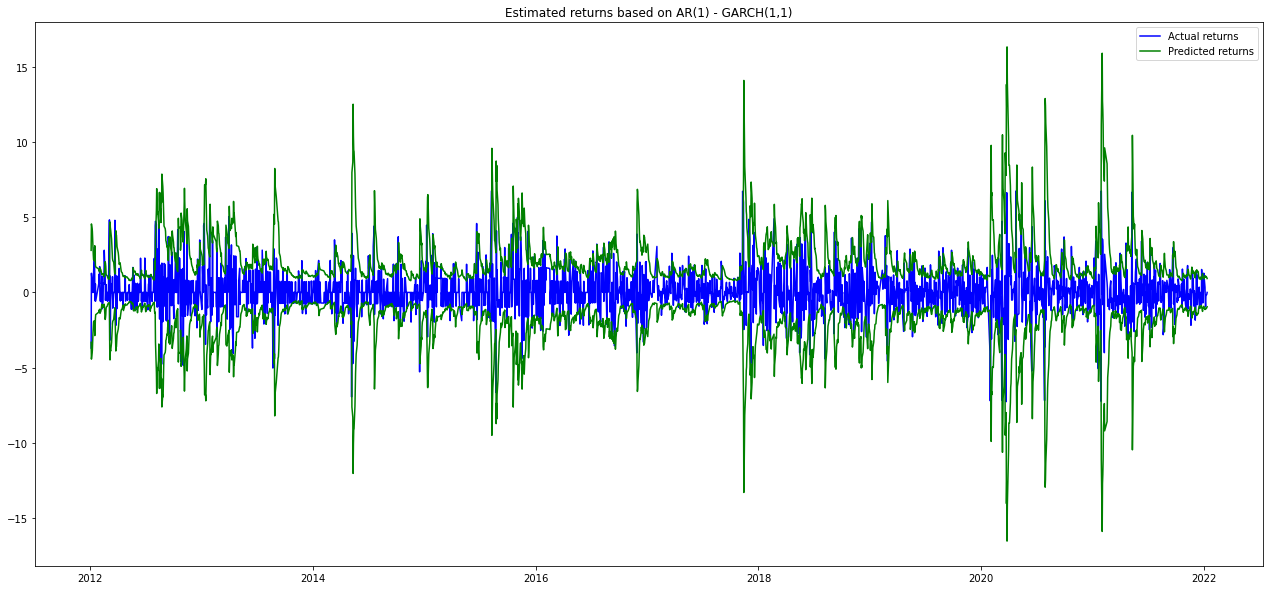

In [42]:
plt.figure(figsize = (22,10))
plt.plot(roll_results['Actual returns'], color = 'blue', label = 'Actual returns')
plt.plot(roll_results['Predicted upper returns'], color = 'green', label = 'Predicted returns')
plt.plot(roll_results['Predicted lower returns'], color = 'green')
plt.legend()
plt.title(f'Estimated returns based on AR(1) - GARCH(1,1)')
plt.show()

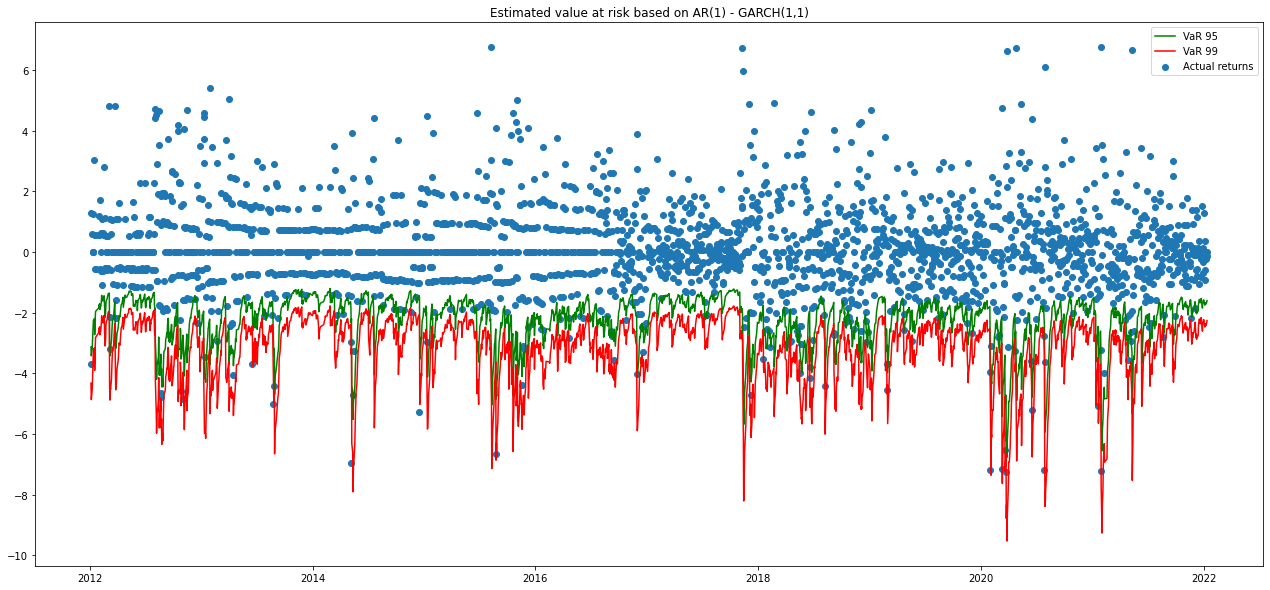

In [43]:
plt.figure(figsize = (22,10))
plt.scatter(roll_results.index, roll_results['Actual returns'], label = 'Actual returns')
plt.plot(roll_results['Estimated VaR 95'], color = 'green', label = 'VaR 95')
plt.plot(roll_results['Estimated VaR 99'], color = 'red', label = 'VaR 99')
plt.legend()
plt.title(f'Estimated value at risk based on AR(1) - GARCH(1,1)')
plt.show()

In [44]:
excess_VaR95 = 0
excess_VaR99 = 0

for i in roll_results.index:
  if roll_results.at[i, 'Estimated VaR 95'] > roll_results.at[i, 'Actual returns']:
    excess_VaR95 += 1
  
  if roll_results.at[i, 'Estimated VaR 99'] > roll_results.at[i, 'Actual returns']:
    excess_VaR99 += 1

In [45]:
print(f'Number of values that exceeds the estimated VaR 95: {excess_VaR95}\nNumber of values that exceeds the estimated VaR 99: {excess_VaR99}')

Number of values that exceeds the estimated VaR 95: 104
Number of values that exceeds the estimated VaR 99: 36


In [46]:
MSE_u = mean_squared_error(y_true = roll_results['Actual returns'], y_pred = roll_results['Predicted upper returns'])
MSE_l = mean_squared_error(y_true = roll_results['Actual returns'], y_pred = roll_results['Predicted lower returns'])

MAE_u = mean_absolute_error(y_true = roll_results['Actual returns'], y_pred = roll_results['Predicted upper returns'])
MAE_l = mean_absolute_error(y_true = roll_results['Actual returns'], y_pred = roll_results['Predicted lower returns'])

MAPE_u = mean_absolute_percentage_error(y_true = roll_results['Actual returns'], y_pred = roll_results['Predicted upper returns'])
MAPE_l = mean_absolute_percentage_error(y_true = roll_results['Actual returns'], y_pred = roll_results['Predicted lower returns'])

SMAPE_u = smape(y_true = roll_results['Actual returns'], y_pred = roll_results['Predicted upper returns'])
SMAPE_l = smape(y_true = roll_results['Actual returns'], y_pred = roll_results['Predicted lower returns'])

In [47]:
print(f'MSE of upper predictions: {MSE_u}\nMSE of lower predictions: {MSE_l}\nMAE of upper predictions: {MAE_u}\nMAE of lower predictions: {MAE_l}\nMAPE of upper predictions: {MAPE_u}\nMAPE of lower predictions: {MAPE_l}\nSMAPE of upper predictions: {SMAPE_u}\nSMAPE of lower predictions: {SMAPE_l}')

MSE of upper predictions: 10.072698108404298
MSE of lower predictions: 10.525608495777076
MAE of upper predictions: 2.408839733259606
MAE of lower predictions: 2.3511300299080657
MAPE of upper predictions: 1417137770614043.8
MAPE of lower predictions: 1252802732487660.2
SMAPE of upper predictions: 150.18167320365745
SMAPE of lower predictions: 149.31041574903932
